# **Malicious URL Detection**

This project uses pyspark for handling massive dataset. First, we are going to install pyspark in our jupyter notebook.

In [ ]:
#Installing python dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark


     |████████████████████████████████| 217.8MB 58kB/s 
     |████████████████████████████████| 204kB 49.5MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=dc908ce67b71fa1ce512f51584ad728a211ec0946e9271b279f7d502ada7a923
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [ ]:
#Setting up environment variable for spark and java
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [ ]:
#creating spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Malicious URL Detection").getOrCreate()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
data_df = spark.read.csv(path="/content/drive/My Drive/Colab Notebooks/dataset.csv",
                        sep=',',
                        encoding='UTF-8',
                        comment=None,
                        header=True, 
                        inferSchema=True)

In [ ]:
data_df.show(5) #viewing initial 5 rows, note that it is spark dataframe and not pandas

+--------------------+-----+
|                 url|label|
+--------------------+-----+
|http://br-ofertas...|    1|
|https://semana-da...|    1|
|https://scrid-app...|    1|
|http://my-softban...|    1|
|http://www.my-sof...|    1|
+--------------------+-----+
only showing top 5 rows



In [ ]:
#lets print schema, it is equivalent to data_df.info() in pandas
data_df.printSchema()

root
 |-- url: string (nullable = true)
 |-- label: integer (nullable = true)



In [ ]:
#Lets visualize this using pandas dataframe
df=pd.DataFrame(data_df.take(5), columns=data_df.columns)
df

,url,label
0,http://br-ofertasimperdiveis.epizy.com/produto...,1
1,https://semana-da-oferta.com/produtos.php?id=5...,1
2,https://scrid-apps-creacust-sslhide90766752024...,1
3,http://my-softbank-security.com/wap_login.htm,1
4,http://www.my-softbank-security.com/wap_login.htm,1


In [ ]:
pandas_df = data_df.select("*").toPandas()
X= pandas_df.groupby("label").count()
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056937 entries, 0 to 1056936
Data columns (total 2 columns):
url      1056937 non-null object
label    1056937 non-null int32
dtypes: int32(1), object(1)
memory usage: 12.1+ MB


In [ ]:
X=data_df.groupby('label').count().toPandas()
X

,label,count
0,1,56937
1,0,1000000


Undersample the unbalanced dataset

In [ ]:
malicious_url = data_df.filter("label = 1")
bening_url = data_df.filter("label = 0")

In [ ]:
malicious_url.count()

56937

In [ ]:
bening_url.count()

1000000

<BarContainer object of 2 artists>

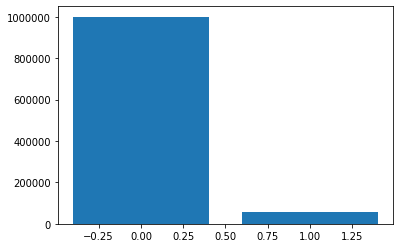

In [ ]:
Y=[bening_url.count(),malicious_url.count()]
X=[0,1]
plt.bar(X,Y)

In [ ]:
#calculating sample ratio
sample_ratio= malicious_url.count() / data_df.count()
sample_ratio

0.053869814378718885

In [ ]:
sample_bening = bening_url.sample(False, sample_ratio)
sample_bening.count()

53822

In [ ]:
#union of all data
sampled_data = malicious_url.unionAll(sample_bening)

<BarContainer object of 2 artists>

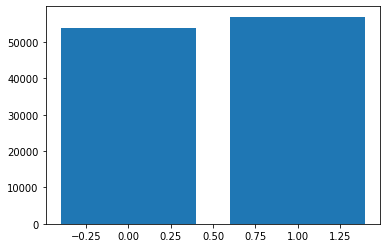

In [ ]:
Y=[sample_bening.count(), malicious_url.count()]
plt.bar(X,Y)

In [ ]:
#check sampled data count
sampled_data.groupby('label').count().toPandas()

,label,count
0,1,56937
1,0,53822


# **Data Tokenization**
Sparsing url data to break into words

In [ ]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer,StopWordsRemover, CountVectorizer
regexTokenizer = RegexTokenizer(inputCol="url", outputCol="Words", pattern="\\W")
regexTokenizer

RegexTokenizer_f09ea833c5df

In [ ]:
#we will now use count vectorizer which will convert words into feature vector i.e rows x 1 format
Count_Vectors = CountVectorizer(inputCol=regexTokenizer.getOutputCol(), outputCol="Raw Features", vocabSize=10000, minDF=5)
Count_Vectors

CountVectorizer_26a77fd84785

In [ ]:
from pyspark.ml.feature import IDF
#Tf-idf weight used for evaluate how importance a keyword to document in to collection of document using statistic measure.
#IDF is being used to check relevance of a keyword against a particular document.
idf = IDF(inputCol=Count_Vectors.getOutputCol(), outputCol="features") 
idf

IDF_ca02fbbdac2e

In [ ]:
#We are now going to create a pipeline. A pipeline is necessary to represent the workflow of a ML model.
#It tells us about transformers and estimators
#creating our pipline 
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[regexTokenizer, Count_Vectors, idf ])
#There are three stages in pipeline, first is regex tokenizer that transforms raw urls into words, second stage converts words 
#into feature vectors and then idf is applied to check relevance of those keywords.


In [ ]:
#Now, need to fit the pipeline on training document
#we will be passing sampled_data(undersampled) into the pipeline to fit this. This is an estimator.
PipelineFit = pipeline.fit(sampled_data) #This actually produces a transformer that can be fed into model


In [ ]:
#transforming the sampled data into dataset 
data_set = PipelineFit.transform(sampled_data)
#So, the data can now be split into training(80%) and testing (20%) using random function
(training_Data, test_Data) = data_set.randomSplit([0.8, 0.2], seed = 100) #setting seed to 100 for randon row selection

In [ ]:
#Let's check training dataset count
print("Training Dataset Count: " + str(training_Data.count()))


Training Dataset Count: 88458


In [ ]:
#Checking testing dataset count
print("Testing Dataset Count: " + str(test_Data.count()))

Testing Dataset Count: 22301


In [ ]:
#What about total data count?
print("Total Dataset Count: " + str(data_set.count()))

Total Dataset Count: 110759


In [ ]:
#show initial 10 rows of dataset
data_set.show(10)

+--------------------+-----+--------------------+--------------------+--------------------+
|                 url|label|               Words|        Raw Features|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|http://br-ofertas...|    1|[http, br, oferta...|(6960,[0,1,2,3,19...|(6960,[0,1,2,3,19...|
|https://semana-da...|    1|[https, semana, d...|(6960,[0,3,6,19,2...|(6960,[0,3,6,19,2...|
|https://scrid-app...|    1|[https, scrid, ap...|(6960,[0,6,845],[...|(6960,[0,6,845],[...|
|http://my-softban...|    1|[http, my, softba...|(6960,[0,1,29,158...|(6960,[0,1,29,158...|
|http://www.my-sof...|    1|[http, www, my, s...|(6960,[0,1,4,29,1...|(6960,[0,1,4,29,1...|
|http://diadesalda...|    1|[http, diadesalda...|(6960,[0,1],[1.0,...|(6960,[0,1],[0.55...|
|https://sites.goo...|    1|[https, sites, go...|(6960,[0,6,28,30,...|(6960,[0,6,28,30,...|
|http://protvinowi...|    1|[http, protvinowi...|(6960,[1,14],[1.0...|(6960,[1,1

In [ ]:
print("Number of features: ", len(data_set.select("features").take(1)[0][0]))

Number of features:  6960


In [ ]:
#checking the count of 1's and 0's in training data
training_Data.groupby('label').count().toPandas()

,label,count
0,1,45493
1,0,42965


In [ ]:
#without sampling
data_set= PipelineFit.transform(data_df)
(training_Data, test_Data) = data_set.randomSplit([0.8, 0.2], seed = 100) #setting seed to 100 for randon row selection
logistic = LogisticRegression(maxIter=10000, regParam=0.3, elasticNetParam=0, family = "binomial")
#training model using logistic regression
logisticModel = logistic.fit(training_Data)
#making predictions based on training data, note that label is not used here
predictions = logisticModel.transform(test_Data)


[Row(label=0), Row(label=0), Row(label=0), Row(label=0), Row(label=0)] [Row(prediction=0.0), Row(prediction=0.0), Row(prediction=0.0), Row(prediction=0.0), Row(prediction=0.0)]


In [ ]:
test_Data.groupby('label').count().toPandas()

,label,count
0,1,11423
1,0,200479


In [ ]:
predictions.groupby('prediction').count().toPandas()

,prediction,count
0,0.0,204527
1,1.0,7375


In [ ]:
#Actual training data had approx 11K malicious and 2 lac non-malicious urls
#Without sampling, predicted malicious urls are 7K and non-malicious 2lac
test_Data.count()

211902

In [ ]:
predictions.count()

211902

In [ ]:
#Since it is a classification problem i.e. either the URL is malicious or non-malicious, we are using logistic regression.
#We will iterate 5 times the same model.
from pyspark.ml.classification import LogisticRegression
for i in range(1,6):
  data_set= PipelineFit.transform(sampled_data)
  logistic = LogisticRegression(maxIter=10000, regParam=0.3, elasticNetParam=0, family = "binomial")
  #training model using logistic regression
  logisticModel = logistic.fit(training_Data)
  #making predictions based on training data, note that label is not used here
  predictions = logisticModel.transform(test_Data)
  print(predictions.select("features").take(1), predictions.select("prediction").take(1))


[Row(features=SparseVector(6960, {0: 0.5507})), Row(features=SparseVector(6960, {0: 0.5507})), Row(features=SparseVector(6960, {0: 0.5507})), Row(features=SparseVector(6960, {0: 0.5507})), Row(features=SparseVector(6960, {0: 0.5507}))] [Row(prediction=0.0), Row(prediction=0.0), Row(prediction=0.0), Row(prediction=0.0), Row(prediction=0.0)]
[Row(features=SparseVector(6960, {0: 0.5507})), Row(features=SparseVector(6960, {0: 0.5507})), Row(features=SparseVector(6960, {0: 0.5507})), Row(features=SparseVector(6960, {0: 0.5507})), Row(features=SparseVector(6960, {0: 0.5507}))] [Row(prediction=0.0), Row(prediction=0.0), Row(prediction=0.0), Row(prediction=0.0), Row(prediction=0.0)]
[Row(features=SparseVector(6960, {0: 0.5507})), Row(features=SparseVector(6960, {0: 0.5507})), Row(features=SparseVector(6960, {0: 0.5507})), Row(features=SparseVector(6960, {0: 0.5507})), Row(features=SparseVector(6960, {0: 0.5507}))] [Row(prediction=0.0), Row(prediction=0.0), Row(prediction=0.0), Row(prediction=0

In [ ]:
predictions

DataFrame[url: string, label: int, Words: array<string>, Raw Features: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

# **Confusion Matrix Plotting**


In [ ]:
#Consider 1 as positive(malicious) and 0 as negative(non-malicious)

#Converting predictions into a pandas dataframe
df_predictions = predictions.select('prediction', 'label')

#What is True Positive here?
#A url was malicious and it was predicted as malicious is True Positive(TP)
TP = df_predictions[(df_predictions.label == 1) & (df_predictions.prediction == 1)].count()

#What is True Negative here?
#A url was non-malicious and it was predicted as non-malicious is True Negative(NP)
TN = df_predictions[(df_predictions.label == 0) & (df_predictions.prediction == 0)].count()

#What is False Positive here?
#A url was non-malicious and it was predicted as malicious is False Positive(FP)
FP = df_predictions[(df_predictions.label == 0) & (df_predictions.prediction == 1)].count()

#What is False Negative here?
#A url was malicious and it was predicted as non-malicious is False Negative(FP)
FN = df_predictions[(df_predictions.label == 1) & (df_predictions.prediction == 0)].count()

In [ ]:
print("\nTrue Positives (URL was malicious and predicted as malicious): %g" % TP)
print("True Negative (URL was non-malicious and predicted as non-malicious): %g" % TN)
print("False Positive (URL was non-malicious and predicted as malicious): %g" % FP)
print("False Negative (URL was malicious and predicted as non-malicious): %g" % FN)


True Positives (URL was malicious and predicted as malicious): 10780
True Negative (URL was non-malicious and predicted as non-malicious): 10856
False Positive (URL was non-malicious and predicted as malicious): 1
False Negative (URL was malicious and predicted as non-malicious): 664


In [ ]:
print("Total: %g" % (df_predictions.count()))
 
recall = float(TP)/(TP + FN) 
precision = float(TP) / (TP + FP)
accuracy = float(TP + TN) / (TP + FP + TN + FN)
f1_score = float(precision*recall)/(precision+recall) * 2


Total: 22301


In [ ]:
recall

0.9419783292555051

In [ ]:
precision

0.9999072442259531

In [ ]:
accuracy

0.9701807093852294

In [ ]:
f1_score

0.9700787401574804

In [ ]:
print("\nAccuracy: %g" %(accuracy*100))
print("F-Score: %f1" %(f1_score*100))
print("Recall: %g" %(recall*100))
print("Precision: %g" %(precision*100))


Accuracy: 97.0181
F-Score: 97.0078741
Recall: 94.1978
Precision: 99.9907


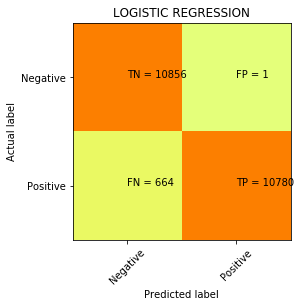

In [ ]:
#Let's plot the model performance
from sklearn.metrics import confusion_matrix

logistic_predictions = logisticModel.transform(test_Data)

y_actual = logistic_predictions.select("label").toPandas()
y_prediction = logistic_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actual, y_prediction)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('LOGISTIC REGRESSION')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


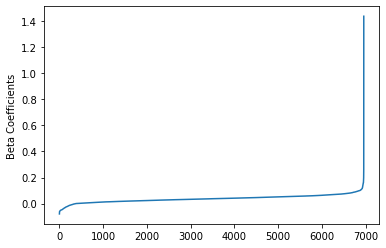

In [ ]:
beta = np.sort(logisticModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

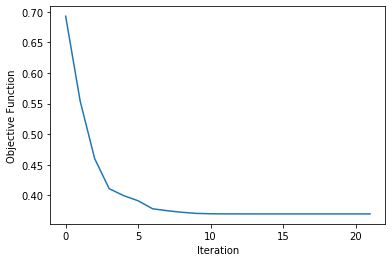

In [ ]:
#Extracting summary of trained Logistic Regression Model instance
training_Summary = logisticModel.summary

#Obtain the objective per iteration
objectiveHistory = training_Summary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()


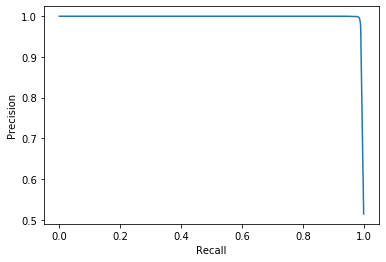

In [ ]:
pr = training_Summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

areaUnderROC: 0.9956674302789228


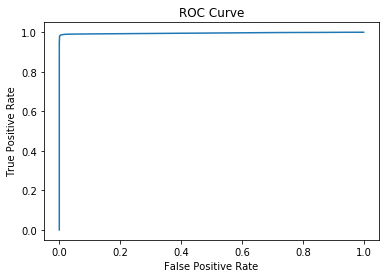

In [ ]:
#ROC Curve
#Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(training_Summary.areaUnderROC))

roc = training_Summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

+---------------+---------------+
|      threshold|      F-Measure|
+---------------+---------------+
|0.9916354104...|0.0158754388...|
|0.9857481419...|0.0306060606...|
|0.9807170793...|0.0441530524...|
|0.9758366287...|0.0589653333...|
|0.9710312426...|0.0733509793...|
|0.9670594088...|0.0882482718...|
|0.9634852975...|0.1046952464...|
|0.9593620225...|0.1191524547...|
|0.9559517253...|0.1334290696...|
|0.9526196132...|0.1468869019...|
+---------------+---------------+
only showing top 10 rows



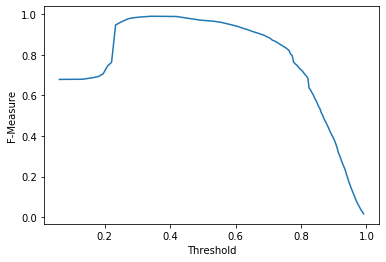

In [ ]:
#Set the model threshold to maximize F-Measure
training_Summary.fMeasureByThreshold.show(n=10, truncate = 15)
f = training_Summary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [ ]:
predictions.filter(predictions['prediction'] == 0).select("url", "label","prediction").orderBy("probability", ascending=False).show(n = 20, truncate = 80)
    

+------------------------------------------+-----+----------+
|                                       url|label|prediction|
+------------------------------------------+-----+----------+
|                        hair-hair-hair.com|    0|       0.0|
|    amoxicillin-no-prescription-amoxil.com|    0|       0.0|
|               20mg-tadalafil-generic.mobi|    0|       0.0|
|withoutprescription-amoxil-amoxicillin.com|    0|       0.0|
|                    prices-buy-levitra.net|    0|       0.0|
|              cheapest-ventolin-buy.online|    0|       0.0|
|                     canada-cialis-buy.org|    0|       0.0|
|             canadian-pharmacy-online.mobi|    0|       0.0|
|               tadalafil-cialis-canada.com|    0|       0.0|
|                                pioneer.jp|    0|       0.0|
|                              izzy-cars.nl|    1|       0.0|
|                       buy-baclofen.reisen|    0|       0.0|
|                     online-buy-lasix.mobi|    0|       0.0|
|       

# **Cross Validation for Logistic Regression**

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Creating ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(logistic.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(logistic.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             .build())

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("\nRoot Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 0.172683


In [ ]:
# Create 10-fold CrossValidator
cv = CrossValidator(estimator=logistic,estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()

In [ ]:
# Run cross validations
cross_validationModel = cv.fit(training_Data)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set here so we can measure the accuracy of our model on new data
predictions = cross_validationModel.transform(test_Data)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.9930049421997263


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

df_predictions = predictions.select('prediction', 'label')

prediction_and_Labels=df_predictions.rdd
metrics = MulticlassMetrics(prediction_and_Labels) 



TP = df_predictions[(df_predictions.label == 1) & (df_predictions.prediction == 1)].count()
TN = df_predictions[(df_predictions.label == 0) & (df_predictions.prediction == 0)].count()
FP = df_predictions[(df_predictions.label == 0) & (df_predictions.prediction == 1)].count()
FN = df_predictions[(df_predictions.label == 1) & (df_predictions.prediction == 0)].count()

print("\nTrue Positives: %g" % TP)
print("True Negative: %g" % TN)
print("False Positive: %g" % FP)
print("False Negative: %g" % FN)


print("Total: %g" % (df_predictions.count()))
 
recall = float(TP)/(TP + FN) #Number of 
precision = float(TP) / (TP + FP)
accuracy = float(TP + TN) / (TP + FP + TN + FN)
f1_score = float(precision*recall)/(precision+recall) * 2


print("F-Score: %f1" %(f1_score*100))
print("\nAccuracy: %g" %(accuracy*100))
print("Recall: %g" %(recall*100))
print("Precision: %g" %(precision*100))


True Positives: 11214
True Negative: 10892
False Positive: 1
False Negative: 230
Total: 22337
F-Score: 98.9805381

Accuracy: 98.9658
Recall: 97.9902
Precision: 99.9911


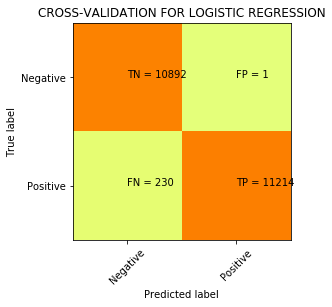

In [ ]:
cv_predictions = cross_validationModel.transform(test_Data)

y_actual = cv_predictions.select("label").toPandas()
y_prediction = cv_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actual, y_prediction)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('CROSS-VALIDATION FOR LOGISTIC REGRESSION')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)


s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# **Naive Bayes**

In [ ]:
#How about training same dataset using Naive Bayes?
from pyspark.ml.classification import NaiveBayes
#Creating naive bayes object
nb = NaiveBayes(smoothing=1, modelType="multinomial",)
 
# train the model
model = nb.fit(training_Data)

# select example rows to display.
predictions = model.transform(test_Data)


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# compute accuracy on the test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.9675280603582117


In [ ]:
df_predictions = predictions.select('prediction', 'label')

TP = df_predictions[(df_predictions.label == 1) & (df_predictions.prediction == 1)].count()
TN = df_predictions[(df_predictions.label == 0) & (df_predictions.prediction == 0)].count()
FP = df_predictions[(df_predictions.label == 0) & (df_predictions.prediction == 1)].count()
FN = df_predictions[(df_predictions.label == 1) & (df_predictions.prediction == 0)].count()

print("\nTrue Positives: %g" % TP)
print("True Negative: %g" % TN)
print("False Positive: %g" % FP)
print("False Negative: %g" % FN)


print("Total: %g" % (df_predictions.count()))
 
recall = float(TP)/(TP + FN) #Number of 
precision = float(TP) / (TP + FP)
accuracy = float(TP + TN) / (TP + FP + TN + FN)
f1_score = float(precision*recall)/(precision+recall) * 2


print("F-Score: %f1" %(f1_score*100))
print("\nAccuracy: %g" %(accuracy*100))
print("Recall: %g" %(recall*100))
print("Precision: %g" %(precision*100))


True Positives: 10913
True Negative: 10691
False Positive: 202
False Negative: 531
Total: 22337
F-Score: 96.7507421

Accuracy: 96.7184
Recall: 95.36
Precision: 98.1826


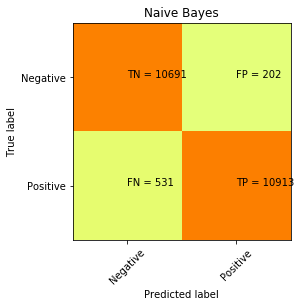

In [ ]:
#plotting naive bayes results
nb_predictions = model.transform(test_Data)

y_actual = nb_predictions.select("label").toPandas()
y_prediction = nb_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actual, y_prediction)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Naive Bayes')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()